# Attention Prediction in a non-calibrated system
The purpose of this notebook is to predict user attention, that is decide wether the user's attention is on the laptop screen or not, using only frames from the laptop camera in real time. For this purpose we have created a dataset with labeled frames(1: looking, 0: not looking) and performed some preproccessing steps in order to extract 68 facial landmarks on the face and the 2 iris points. Below, we will try out different data architectures and classifiers to get the best performance.

In order to achieve real time performance we cannot afford time calibrating the camera, so we wll _approximate a mapping between the 2D camera points and the 3D world_ by solving the [Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) problem using the built-in openCV method solvePnP. This way we will obtain the Rotation and Translation matrix(3x1 each) for each frame and afterwards we will use them in different architectures to train a machine learning model that will predict the final output. The architectures presented below are:
 - Feed the raw two vectors in a classifier.
 - Feed the two vectors and the 2 iris points.

### Import packages

In [2]:
import numpy as np
import cv2
import dlib
from imutils import face_utils
import glob
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json

### 3D Model points for SolvePnP
We will approximate the 3D points of the following face parts with the correspoinding coordinates. This is a general model of the human face and we do not need to worry much about absolute accuracy.

In [3]:
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                         
                        ])

### Load Dataset

In [4]:
# Number of training examples to use(0-3084)
DATASET_SIZE = 3084
DEBUG = False

# Load the dataset
with open('data.json') as json_file:
    data_all = json.load(json_file)

# Extract the keys in sorted order
keys = sorted(data_all)

# Convert python list to np array
keys = np.asarray(keys)
print(keys.shape)

# Uncomment if you want to use a smaller dataset and not the full one
# rand_indices = np.random.randint(3084, size=DATASET_SIZE)
# keys = keys[rand_indices]
print(keys.shape)

(3084,)
(3084,)


***

# Architecture #1

#### In this data architecture we will use as input the translation vector and rotation vector, each one of shape (3, 1) so a signle training example of our dataset will be of shape (6, 1). 

In [5]:
X = np.zeros((DATASET_SIZE, 6, 1))
y = np.zeros(DATASET_SIZE)

for i in range(DATASET_SIZE):
    key = keys[i]
        
    # Check if it is positive or negative example
    output = key.split('/')[1]
    if(output == 'positive'):
        y[i] = 1
    elif(output == 'negative'):
        y[i] = 0
        
    # Approximate camera intrinsic parameters
    im = cv2.imread('dataset/' + key)
    size = im.shape
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    
    landmarks = data_all[key]['landmarks']
    
    # Grab the 2D coordinates of our six sample points
    image_points = np.array([
        (landmarks[33]['x'], landmarks[33]['y']) ,     # Nose tip
        (landmarks[8]['x'], landmarks[8]['y']),     # Chin
        (landmarks[36]['x'], landmarks[36]['y']),     # Left eye left corner
        (landmarks[45]['x'], landmarks[45]['y']),     # Right eye right corner
        (landmarks[48]['x'], landmarks[48]['y']),     # Left Mouth corner
        (landmarks[54]['x'], landmarks[54]['y'])      # Right mouth corner
    ], dtype="double")
    
    # Solve the PnP problem with the parameters specified above
    # and obtain rotation and translation vectors
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
        )
    
    X[i, :] = np.concatenate((rotation_vector, translation_vector), axis=0)
    
    # DEBUGGING
    if(DEBUG and i <= 10):
        # Project a 3D point (0, 0, 1000.0) onto the image plane.
        # We use this to draw a line sticking out of the nose
        (nose_end_point2D, jacobian) = cv2.projectPoints(
            np.array([(0.0, 0.0, 500.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs
            )
        for p in image_points:
            cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
        p1 = ( int(image_points[0][0]), int(image_points[0][1]) )
        p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]) )
        
        # Draw a line connecting the two points. This line must show
        # the direction out of the nose
        cv2.line(im, p1, p2, (255,0,0), 2)
        # Display image
        cv2.imshow("Output", im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        print("Rotation Vector:\n {0}".format(rotation_vector))
        print("Translation Vector:\n {0}".format(translation_vector))


X = X.squeeze()
print(X.shape)
print(y.shape)

(3084, 6)
(3084,)


#### Data Preproccessing: Normalize features to have 0 mean and 1 Std
We obtain the mean and std from the first 800 examples and not the whole dataset beacause computations crush with too many exmaples and give infinite mean and std

In [6]:
print(X[1000:1005, :])

[[-3.00551937e+00  1.45078022e-01  4.76767504e-01  7.95712968e+01
  -3.92782853e+01  2.76019804e+03]
 [-3.04554883e+00  9.05243587e-02 -3.07827588e-01  1.95291887e+02
  -2.31782775e+00  2.75736773e+03]
 [-3.00660977e+00  1.51251722e-01  5.22350233e-01  9.21191347e+01
  -3.85456010e+01  2.76212599e+03]
 [-3.00558778e+00  8.01227450e-02 -2.23640283e-01  2.10849908e+02
   7.66908812e+01  2.71377602e+03]
 [-3.01596605e+00  9.21469966e-02 -1.64322200e-01  1.97475436e+02
   5.58485825e+01  2.73608906e+03]]


#####  Before normalization:

In [7]:
m = X[0:1000, :].mean(axis=0)
std = X[0:1000, :].std(axis=0)

print('Mean: ', m)
print('Std: ', std)

Mean:  [-2.57750853e+00  2.59756409e-02  6.94960123e-02  1.70568095e+02
  5.29112770e+00  2.27197605e+03]
Std:  [1.22773270e+00 6.42579433e-01 4.13830849e-01 2.61512303e+02
 1.73896971e+02 9.22001517e+02]


In [8]:
X_scaled = (X-m)/std

##### After normalization:

In [9]:
print('Mean:', X_scaled[2000:2500].mean(axis=0))
print('Std: ', X_scaled[0:1000].std(axis=0))
print(y.shape)

Mean: [-0.15021119  0.00829007 -0.14881449  0.57646358 -0.49718561 -0.51012038]
Std:  [1. 1. 1. 1. 1. 1.]
(3084,)


### Shuffle and split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

print(y_test.shape)
print(X_train[0:5, :])

(617,)
[[ 2.03885259  3.56580036 -0.18383844  1.98496006  2.07709054 -5.10066859]
 [-0.23773101  0.17326135 -0.40743638  1.17948737 -0.1525981  -0.74234694]
 [-0.37076773  0.22695155  0.58478046  0.44834344  1.29502932 -0.18483583]
 [-0.20603819  0.25720197 -0.73779234 -0.26596978 -0.21049899  0.7113609 ]
 [-0.25452611  0.09243677 -0.37762025  0.30181668 -0.80063143 -0.53737714]]


# Train different classifiers
Here we will try out 3 classifiers and compare their results:
 - A SVM with rbf kernel and penalty parameter C=100
 - A Logistic Regression classifer
 - A Random Forest Classifier

### SVM Classifier

In [13]:
from sklearn import svm
    
svm_classifier = svm.SVC(C=100, kernel='rbf', gamma='auto')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

print('Training set accuracy for SVM:', svm_classifier.score(X_train, y_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y_test, y_pred_svm))

Training set accuracy for SVM: 0.7012565869477098
Test set accuracy for SVM:  0.6450567260940032


### Logistic Regression Classifier

In [14]:
from sklearn.linear_model import LogisticRegression


lr_classifier = LogisticRegression(solver='lbfgs')
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)

print('Training set accuracy for Logistic Regression:', lr_classifier.score(X_train, y_train))
print('Test set accuracy for Logistic Regression: ', metrics.accuracy_score(y_test, y_pred_lr))

Training set accuracy for Logistic Regression: 0.5265504661532225
Test set accuracy for Logistic Regression:  0.5153970826580226


### Random Forst Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
    
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

print('Training set accuracy for Random Forst:', rf_classifier.score(X_train, y_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y_test, y_pred_rf))

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.747163695299838


## Visualize & Summarize results for Architecture #1

We trained the 3 classifiers for 10 different train/test splits and the accuracy results are shown below

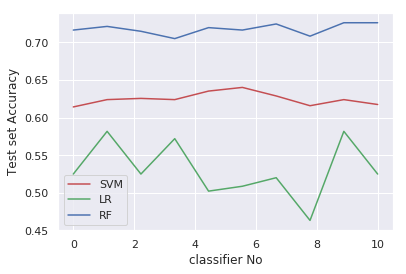

In [57]:
### NOTE: Y1, Y2, Y3 removed from notebook now, so don't run this cell it is just for reference
import matplotlib.pyplot as plt

t = np.linspace(0, 10, 10)
plt.plot(t, Y1, 'r')
plt.plot(t, Y2, 'g')
plt.plot(t, Y3, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'LR', 'RF'))

plt.show()

The best out of 10 scores for each classifier is presented below

Metric                | SVM        | Logistic Regression | Random Forest |
:----:                | :--------: | :-----------------: | :-----:       |
Training set Accuracy | 0.701      | 0.580               | 1             | 
Test set Accuracty    | 0.640      | 0.581               | 0.726         |

We clearly see that the Random Forest classifier with 100 trees outperfomrs the other 2, reaching 72,6% accuracy!

# Architecture #2
#### In this data architecture we will use as input the translation vector and rotation vector plus the 2 iris points) so a signle training example of our dataset will be of shape (10, 1). 
We already have the array X of shape (6, 1) containing the rotation and translation vectors stacked so we only need to extract the iris points from our data.json.

In [16]:
DATASET_SIZE = 3084
X2 = np.zeros((DATASET_SIZE, 10))
for i in range(DATASET_SIZE):
    key = keys[i]
    iris_right = np.asarray(data_all[key]['iris_right'])
    iris_left = np.asarray(data_all[key]['iris_left'])
#     iris = np.concatenate((iris_left, iris_right), axis = 0)
    X2[i, :] = np.concatenate((X[i, :], iris_left, iris_right), axis = 0)
print(X2.shape)

(3084, 10)


The following steps are the same as for the first architecture

In [17]:
print(X2[1000:1005])

[[-3.00551937e+00  1.45078022e-01  4.76767504e-01  7.95712968e+01
  -3.92782853e+01  2.76019804e+03  6.25004729e+02  2.55122853e+02
   7.52216725e+02  2.41467233e+02]
 [-3.04554883e+00  9.05243587e-02 -3.07827588e-01  1.95291887e+02
  -2.31782775e+00  2.75736773e+03  6.51599474e+02  2.74633597e+02
   7.80190422e+02  2.66374984e+02]
 [-3.00660977e+00  1.51251722e-01  5.22350233e-01  9.21191347e+01
  -3.85456010e+01  2.76212599e+03  6.30616018e+02  2.55011379e+02
   7.57703846e+02  2.43255612e+02]
 [-3.00558778e+00  8.01227450e-02 -2.23640283e-01  2.10849908e+02
   7.66908812e+01  2.71377602e+03  6.60564201e+02  3.02714393e+02
   7.92862665e+02  2.95378319e+02]
 [-3.01596605e+00  9.21469966e-02 -1.64322200e-01  1.97475436e+02
   5.58485825e+01  2.73608906e+03  6.54926899e+02  2.94318558e+02
   7.88320997e+02  2.85512182e+02]]


In [20]:
m = X2[0:1000, :].mean(axis=0)
std = X2[0:1000, :].std(axis=0)

X2_scaled = (X2-m)/std

In [21]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
print(y2_test.shape)
print(X2_train[0:5, :])

(617,)
[[-0.30489747  0.44995405 -0.03207482  0.05471082  1.71536595  1.31645203
   1.23072256  2.24415699  1.19848843  2.16262291]
 [-0.30804064 -0.04174062 -1.08036672  0.060418   -0.04080742 -0.66831093
  -0.52168359 -0.56599168 -0.4454114  -0.53480614]
 [-0.16597413  0.07393728  1.19308561  0.62562851  0.28793835 -0.64609178
  -0.12759805 -0.35122837 -0.03019726 -0.33639984]
 [-0.33035783 -0.0408077  -0.23098623 -0.19463542 -1.11718155 -0.43345632
  -0.61372257 -1.10051383 -0.5810407  -1.15838966]
 [-0.21075689  0.26413389  0.69838829 -0.48411698 -0.42189342 -0.5054249
  -0.7397101  -0.70185695 -0.69339691 -0.85616095]]


# Train different classifiers
Here we will try out 3 classifiers and compare their results:
 - A SVM with rbf kernel and penalty parameter C=100
 - A Logistic Regression classifer
 - A Random Forest Classifier

### SVM classifier

In [39]:
from sklearn import svm

svm_classifier2 = svm.SVC(C=100, kernel='rbf', gamma='auto')
svm_classifier2.fit(X2_train, y2_train)
y2_pred_svm = svm_classifier2.predict(X2_test)

print('Training set accuracy for SVM:', svm_classifier2.score(X2_train, y2_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y2_test, y2_pred_svm))

Training set accuracy for SVM: 0.7450344548034049
Test set accuracy for SVM:  0.7163695299837926


### Logistic Regression Classifier

In [40]:
from sklearn.linear_model import LogisticRegression

lr_classifier2 = LogisticRegression(solver='lbfgs')
lr_classifier2.fit(X2_train, y2_train)
y2_pred_lr = lr_classifier2.predict(X2_test)

print('Training set accuracy for Logistic Regression:', lr_classifier2.score(X2_train, y2_train))
print('Test set accuracy for Logistic Regression: ', metrics.accuracy_score(y2_test, y2_pred_lr))

Training set accuracy for Logistic Regression: 0.4702067288204297
Test set accuracy for Logistic Regression:  0.47649918962722854


### Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier2 = RandomForestClassifier(n_estimators=100, random_state=1)
rf_classifier2.fit(X2_train, y2_train)
y2_pred_rf = rf_classifier2.predict(X2_test)

print('Training set accuracy for Random Forst:', rf_classifier2.score(X2_train, y2_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y2_test, y2_pred_rf))

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.7406807131280388


## Visualize & Summarize results for Architecture #2


We trained the 3 classifiers for 25 different train/test splits and the accuracy results are shown below

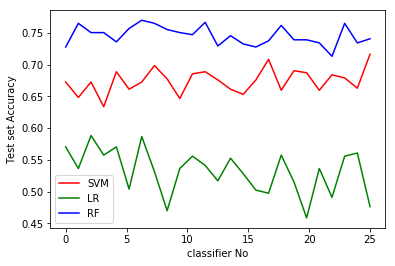

0.7163695299837926 0.5883306320907618 0.7698541329011345


In [42]:
### NOTE: Y1, Y2, Y3 removed from notebook now, so don't run this cell it is just for reference
import matplotlib.pyplot as plt

t = np.linspace(0, N, N)
plt.plot(t, Y1, 'r')
plt.plot(t, Y2, 'g')
plt.plot(t, Y3, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'LR', 'RF'))

plt.show()
print(Y1.max(axis=0), Y2.max(axis=0), Y3.max(axis=0))

Metric                | SVM        | Logistic Regression | Random Forest |
:----:                | :--------: | :-----------------: | :-----:       |
Training set Accuracy | 0.752      | 0.533               | 1             | 
Test set Accuracty    | 0.716      | 0.588               | 0.770         |

The difference with the first architecture is obvious! The SVM is much more accurate now approaching the Random Forest accuracy, which also improved in but not as much as the SVM. Also the Logistic Regression classifier seems unable to handle our Dataset in both situations so we will not consinder it for the next of our research. The best accuracy scored is achieved by Random Forest classifier and the second data architecture, reaching 77%!